n ideal 18.687880855628215
n_actual 19
[ 6.49002747 12.37442832 17.95856895 23.10695258 27.69465589 31.6103602
 34.75905263 37.0643315  38.47026021 38.94272449 38.47026021 37.0643315
 34.75905263 31.6103602  27.69465589 23.10695258 17.95856895 12.37442832
  6.49002747]
[ 6. 13. 18. 23. 28. 31. 35. 37. 39. 38. 39. 37. 35. 31. 28. 23. 18. 13.
  6.]
[0.08947256020449472, 0.23719886669318815, 0.4027158415806615, 0.5585961153385705, 0.7136158353927631, 0.871080909885953, 1.0239453760989525, 1.181000030320636, 1.3366630473416072, 1.4947229733074425, 1.6468696802823508, 1.8049296062481859, 1.9605926232691573, 2.117647277490841, 2.2705117437038407, 2.4279768181970303, 2.582996538251223, 2.7388768120091314, 2.904393786896605, 3.0521200933852985]
0.15592881753583177
3.1185763507166353
thetas with caps [0.         0.08947256 0.23719887 0.40271584 0.55859612 0.71361584
 0.87108091 1.02394538 1.18100003 1.33666305 1.49472297 1.64686968
 1.80492961 1.96059262 2.11764728 2.27051174 2.42797682 2.58299

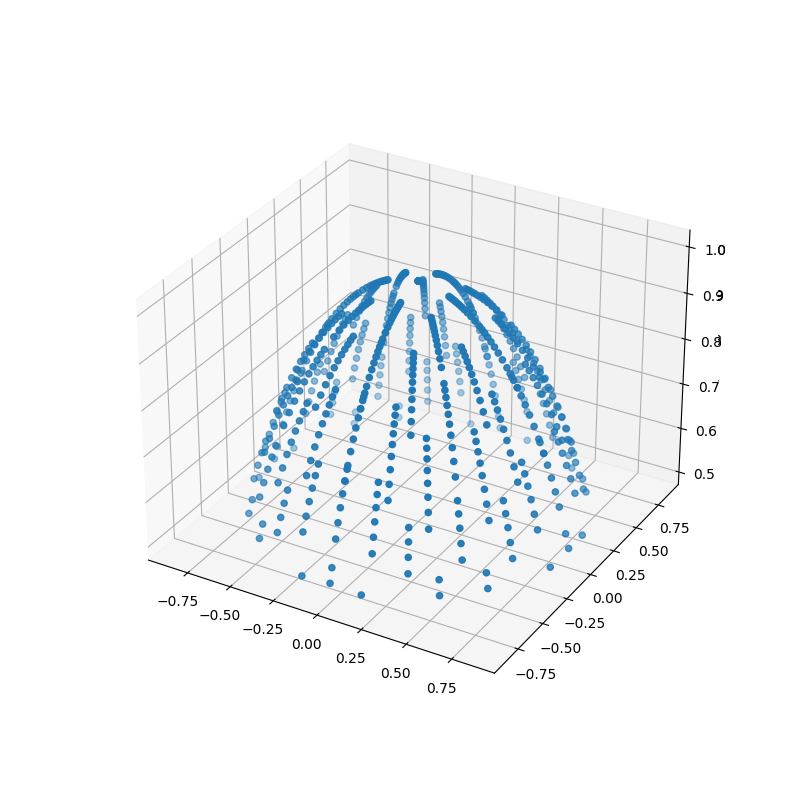

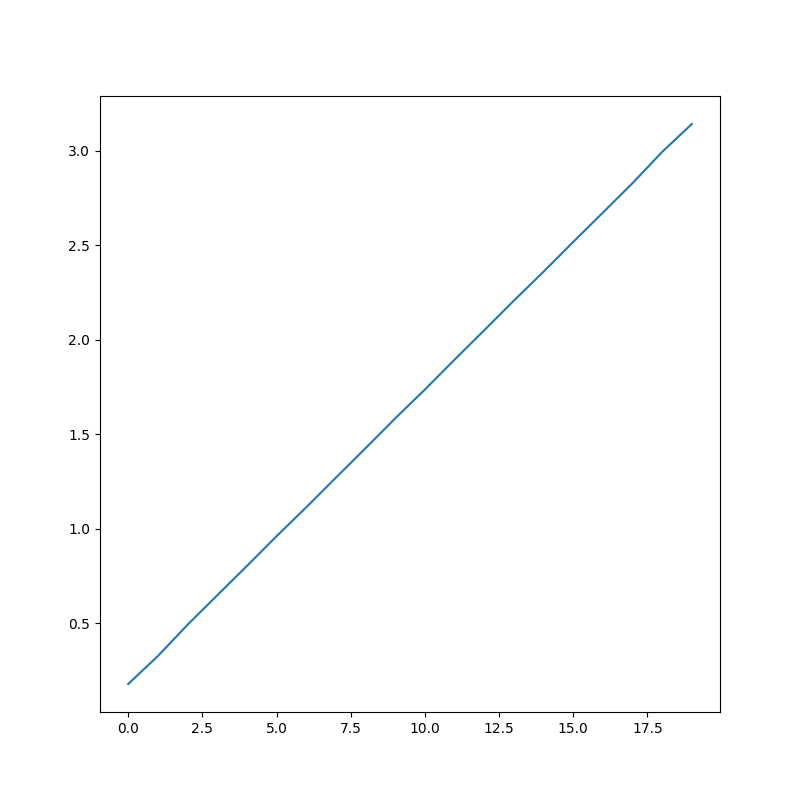

In [4]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib widget
NA = 0.5
ray_count = 500

scale = 1/(1-np.pi/6)
npoints = int(np.round(((
    2*scale*ray_count)**(1/3))
    ))
        
x = np.linspace(-1,1,npoints)
y = np.linspace(-1,1,npoints)
z = np.linspace(1-(NA),1,int(np.round(npoints/(2*NA))))

xm, ym, zm = np.meshgrid(x, y, z)

r_vals =  xm*xm + ym*ym + zm*zm
r_mask = r_vals < 1
# z_mask = z >= 0  # only want half of sphere (each dipole is symmetric)

# remove [0,0,0], remove points outside sphere, normalise onto surface
nonzero_points = r_vals > 0
r_vals_masked = r_vals[r_mask & nonzero_points]
x_vals = xm[r_mask & nonzero_points]/r_vals_masked**0.5
y_vals = ym[r_mask & nonzero_points]/r_vals_masked**0.5
z_vals = zm[r_mask & nonzero_points]/r_vals_masked**0.5


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(xm,ym,zm)

fig2 = plt.figure(figsize=(8,8))
ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter3D(x_vals,y_vals,z_vals)

# fibonacci
n = ray_count
phi = (1+5**0.5)/2
xi = [(i/phi) % 1 for i in range(n+1)]
yi = [i/n for i in range(n+1)]

# zonal equal area partition Rakhmanov et al
# polar cap radius
N = ray_count
r_c = np.arccos(1-2/N)
delta_ideal = (4*np.pi/N)**0.5
n_ideal = (np.pi - 2*r_c)/delta_ideal
n_actual = np.max([1, int(np.round(n_ideal))])
print("n ideal", n_ideal)
print("n_actual", n_actual)
delta_fitting = delta_ideal*n_ideal/n_actual
A_i = [2*np.pi*(np.cos(r_c + (i-2)*delta_fitting) - \
    np.cos(r_c + (i - 1)*delta_fitting)) for i in range(2,n_actual+2)]
n_cells_ideal = N*np.array(A_i)/(4*np.pi)
print(n_cells_ideal)
n_cells_actual = np.zeros_like(n_cells_ideal)

a_j = 0
# j= {2, ... n+1}, actual range is 1 to n+2 including caps/poles
for j in range(n_actual):
    n_cells_actual[j] = np.round(n_cells_ideal[j] + a_j)
    a_j = np.sum(n_cells_ideal[0:j+1]-n_cells_actual[0:j+1])

print(n_cells_actual)

# add the first pole point (y1 in literature)
n_cells_actual_w_cap = np.append(1, n_cells_actual)

thetas = \
    [np.arccos(1 - (2/N)*np.sum(n_cells_actual_w_cap[0:j+1])) for j in range(0, n_actual+1)]
plt.plot(thetas+r_c)
print(thetas)
print(delta_fitting)
print(delta_fitting*20)
# print("theta plus r_c", thetas+r_c)
thetas_with_caps = np.concatenate(([0], thetas, [np.pi]))
# thetas_with_caps = np.concatenate(thetas_with_caps, np.pi)
print("thetas with caps", thetas_with_caps)
print(r_c)


In [ ]:
r_vals_masked == 0

In [ ]:
from scipy.spatial import Delaunay
from scipy.spatial import KDTree
from scipy.spatial import Voronoi
from scipy.spatial import SphericalVoronoi, geometric_slerp
from mpl_toolkits.mplot3d import proj3d
from scipy.spatial import voronoi_plot_2d
from matplotlib import pyplot as plt
import numpy as np
%matplotlib widget

NA = 0.9
ray_count = 500




# now convert to polar, reject r coordinate (project onto unit sphere)?
# replace zeroes with very small numbers e.g. 1e-15?


k_max = ray_count
# N scales so that same number of rays for different NA
N = (2*ray_count - 1)/(1-(1-NA**2)**0.5)  
zk = np.array([1 - (2*k - 1)/N for k in range(1, k_max+1)])
theta_k = np.arccos(zk)
L = (N*np.pi)**0.5
phi_k = (L*theta_k) % (2*np.pi)

x = np.sin(theta_k)*np.cos(phi_k)
y = np.sin(theta_k)*np.sin(phi_k)
z = np.cos(theta_k)

points = np.array([x,y,z]).T

# tri = Delaunay(points)
# tree = KDTree(points)
# vor = Voronoi(points)
radius = 1
center = np.array([0, 0, 0])
sv = SphericalVoronoi(points, radius, center)
# vor.vertices
# sort vertices (optional, helpful for plotting)
sv.sort_vertices_of_regions()
t_vals = np.linspace(0, 1, 2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
# plot the unit sphere for reference (optional)
"""
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='y', alpha=0.1)
"""
# plot generator points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b')
# plot Voronoi vertices
ax.scatter(sv.vertices[:, 0], sv.vertices[:, 1], sv.vertices[:, 2],
                   c='g')
# indicate Voronoi regions (as Euclidean polygons)
for region in sv.regions:
   n = len(region)
   for i in range(n):
       start = sv.vertices[region][i]
       end = sv.vertices[region][(i + 1) % n]
       result = geometric_slerp(start, end, t_vals)
       ax.plot(result[..., 0],
               result[..., 1],
               result[..., 2],
               c='k')
ax.azim = 10
ax.elev = 40
_ = ax.set_xticks([])
_ = ax.set_yticks([])
_ = ax.set_zticks([])
fig.set_size_inches(10, 10)
plt.show()


"""
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_aspect('equal', adjustable='box')

voronoi_plot_2d(vor, ax=ax)
"""